In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 

In [2]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_tracking = compute_orientation(df_tracking)
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

In [3]:
animate_play(df_tracking,df_play,df_players,df_pffScoutingData, 2021091200, 122, displayZone=True, displayOrientations=False).show()

 PlayId : 1422 - (8:38) (Shotgun) B.Roethlisberger pass short right to J.Smith-Schuster to BUF 45 for 10 yards (J.Poyer).


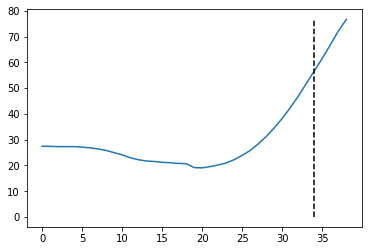

In [6]:
df_tracking = pd.read_csv("data/week1.csv")
gameId = 2021091201
playId = 1422

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in [playId]:#playIds[:5]:
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()    
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)


    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {playId} - {playDescription}")
    aire_t = list()
    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
    else :
        eventFrame = 1000
    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))

    plt.plot(aire_t)
    plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    plt.show()
    

  0%|          | 0/97 [00:00<?, ?it/s]

 PlayId : 2279 - (1:11) (Shotgun) D.Prescott sacked at TB 33 for -12 yards (S.Barrett).


 45%|████▌     | 44/97 [00:07<00:08,  6.24it/s]

 PlayId : 2330 - (:28) (Shotgun) D.Prescott scrambles left end pushed ob at TB 42 for 1 yard (S.Barrett; W.Gholston). TB-W.Gholston was injured during the play. His return is Questionable. 


 47%|████▋     | 46/97 [00:13<00:18,  2.78it/s]

 PlayId : 3364 - (2:03) (Shotgun) D.Prescott scrambles up the middle to TB 25 for 2 yards (D.White).


100%|██████████| 97/97 [00:18<00:00,  5.18it/s]


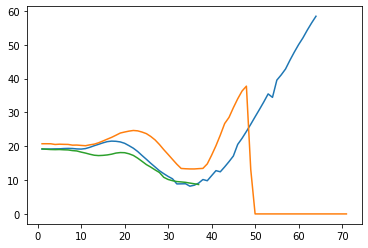

In [7]:
gameId = 2021090900

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in tqdm(playIds):
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    if 'SCRAMBLE' in selected_play_df.dropBackType.unique():  
        tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
        tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)

        sorted_frame_list = selected_tracking_df.frameId.unique()
        sorted_frame_list.sort()
        if selected_play_df.empty :
            print(playId)
            continue
        line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
        playDescription = selected_play_df.playDescription.values[0]
        print(f" PlayId : {playId} - {playDescription}")

        QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
        QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
        aire_t = list()

        for frameId in sorted_frame_list:
            #if eventFrame == frameId :
            #    break
            selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
            offensive_points = get_Oline_position(selected_frame_df)
            defensive_points = get_Dline_position(selected_frame_df)
            QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
            region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
            aire_t.append(pocketArea(region_polys, region_pts, players_points))
        plt.plot(sorted_frame_list, aire_t)

Total n° of plays : 8557
n° of scramble plays : 1047


  0%|          | 0/1047 [00:00<?, ?it/s]

 PlayId : 2021090900 - 735 - (2:45) (Shotgun) D.Prescott pass short right to M.Gallup ran ob at TB 29 for 8 yards.


/tmp/ipykernel_219883/3737302287.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



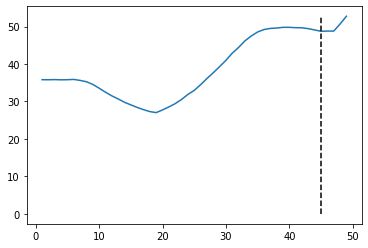

  0%|          | 1/1047 [00:05<1:41:33,  5.83s/it]

 PlayId : 2021090900.0 - 1425.0 - (9:04) D.Prescott pass short right to B.Jarwin pushed ob at TB 33 for 6 yards (J.Pierre-Paul). Tampa Bay challenged the pass completion ruling, and the play was Upheld. The ruling on the field stands. (Timeout #1.)


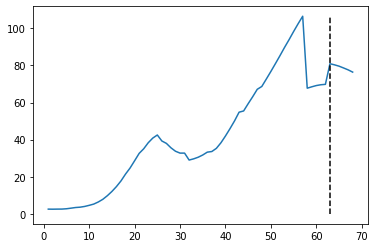

  0%|          | 2/1047 [00:13<1:55:38,  6.64s/it]

 PlayId : 2021090900.0 - 2279.0 - (1:11) (Shotgun) D.Prescott sacked at TB 33 for -12 yards (S.Barrett).


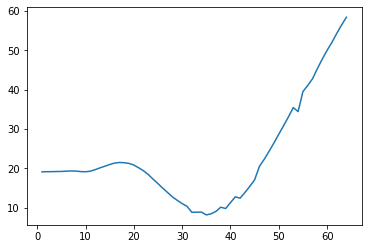

  0%|          | 3/1047 [00:22<2:12:57,  7.64s/it]


KeyboardInterrupt: 

In [8]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "'SCRAMBLE' in dropBackType | 'SCRAMBLE_ROLLOUT_RIGHT' in dropBackType | 'SCRAMBLE_ROLLOUT_LEFT' in dropBackType"
scramble_plays = df_play.query(scramble_mask)#[["gameId","playId","dropBackType"]]
print(f'n° of scramble plays : {len(scramble_plays)}')
for scramble_id in tqdm(range(len(scramble_plays))):

    scramble_play = scramble_plays.iloc[scramble_id].playId
    scramble_game = scramble_plays.iloc[scramble_id].gameId

    selected_play_df = df_play[(df_play.playId==scramble_play)&(df_play.gameId==scramble_game)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==scramble_play)&(tracking_players_df.gameId==scramble_game)].copy()
    selected_tracking_df = beaten_by_defender(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    selected_tracking_df = scramble(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {scramble_game} - {scramble_play} - {playDescription}")

    QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
    QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
    aire_t = list()

    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))
    aire_min_during_scramble = np.min(aire_t)
    scramble_plays.loc[scramble_id, 'scrambleArea'] = aire_min_during_scramble
#print(scramble_plays[['gameId','playId','scrambleArea']])

    plt.plot(sorted_frame_list, aire_t)

    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
        plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    else :
        eventFrame = 1000
    plt.show()


In [33]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 
from multiprocessing import Pool
from scipy.signal import argrelextrema

df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_tracking = compute_orientation(df_tracking)
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")


def features_one_play(playId) : 
    gameId = df_area[df_area.playId == playId].gameId.unique()[0]
    print(f'{playId} - {gameId}')
    selected_area_df = df_area[(df_area.playId==playId)&(df_area.gameId==gameId)].copy() 
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(gameId, playId , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    #try :
    selected_tracking_df = scramble(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    event, te, tsnap = compute_t_event(gameId, playId, selected_play_df, df_pffScoutingData, selected_tracking_df)
    print(tsnap,te)
    Ae = selected_area_df[selected_area_df.frameId == te].Area.iloc[0]
    print(np.array(selected_area_df[(selected_area_df.frameId > tsnap)&(selected_area_df.frameId < te)].Area.values.tolist()))
    t_extrema = argrelextrema(np.array(selected_area_df[(selected_area_df.frameId > tsnap)&(selected_area_df.frameId< te)].Area.values.tolist()), np.greater)[0]
    print(t_extrema)
    if len(t_extrema) > 0 :
        print('local maxima found')
        tc = t_extrema[-1] + 1 
        print(tc)
        Ac = selected_area_df[selected_area_df.frameId == tc + tsnap].Area.iloc[0]
        print(Ac)
    else :
        print('global max found')
        Ac = np.max(selected_area_df[(selected_area_df.frameId > tsnap) & (selected_area_df.frameId < te)].Area)
        tc = selected_area_df[selected_area_df.Area == Ac].frameId.iloc[0] - tsnap
    te = te - tsnap
    one_play =  pd.DataFrame([[playId, gameId, event, te, Ae, tc, Ac, tsnap]], 
                            columns = ['playId', 'gameId', 'event', 'te', 'Ae', 'tc', 'Ac', 'tsnap'])
        #one_play.to_csv(f'data/area_features/plays/play{playId}_game{gameId}.csv')
        #return one_play
    #except : 
    #        print('Problème pour gameId, playId : ' + str((gameId, playId)))

    return one_play

df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area = pd.read_csv(f"data/area/week{1}.csv")
playIds = [500]#df_area.playId.unique()

with Pool() as mp_pool:
    week_features = mp_pool.map(features_one_play, playIds)
print(week_features)


500 - 2021091201
5 27
[43.79175    44.57015    44.8398     44.8179     44.252      42.88095
 40.9761     38.45865    35.81235    33.12945    29.19857119 27.67265
 25.52225    25.4776     27.01165    28.588      29.9839     31.22625
 32.24555    34.30705    36.47345   ]
[2]
local maxima found
3
44.83980000000003
[   playId      gameId     event  te        Ae  tc       Ac  tsnap
0     500  2021091201  scramble  22  39.06245   3  44.8398      5]


In [4]:
df_area_1 = pd.read_csv(f"data/area/week{1}.csv")
df_area_2 = pd.read_csv(f"data/area/week{2}.csv")
df_area_3 = pd.read_csv(f"data/area/week{3}.csv")
df_area_4 = pd.read_csv(f"data/area/week{4}.csv")
df_area_5 = pd.read_csv(f"data/area/week{5}.csv")
df_area_6 = pd.read_csv(f"data/area/week{6}.csv")
df_area_7 = pd.read_csv(f"data/area/week{7}.csv")
df_area_8 = pd.read_csv(f"data/area/week{8}.csv")
print(len(df_area_1)+len(df_area_2)+len(df_area_3)+len(df_area_4)+len(df_area_5)+len(df_area_6)+len(df_area_7)+len(df_area_8))
print(df_area_1)
df_area_all_weeks = pd.concat([df_area_1,
                            df_area_2,
                            df_area_3,
                            df_area_4,
                            df_area_5,
                            df_area_6,
                            df_area_7,
                            df_area_8])

print(len(df_area_all_weeks))
print(df_area_all_weeks)
df_area_all_weeks.to_csv('data/area/area_t.csv')

361370
       Unnamed: 0  frameId       Area  playId      gameId
0               0        1  22.319900      97  2021090900
1               0        2  22.162750      97  2021090900
2               0        3  22.160150      97  2021090900
3               0        4  22.453350      97  2021090900
4               0        5  22.727850      97  2021090900
...           ...      ...        ...     ...         ...
48581           0       30  26.358933    4845  2021091300
48582           0       31  25.956274    4845  2021091300
48583           0       32  26.037736    4845  2021091300
48584           0       33  24.388550    4845  2021091300
48585           0       34  18.450469    4845  2021091300

[48586 rows x 5 columns]
361370
       Unnamed: 0  frameId       Area  playId      gameId
0               0        1  22.319900      97  2021090900
1               0        2  22.162750      97  2021090900
2               0        3  22.160150      97  2021090900
3               0        4  22.4

In [14]:
df_area_t = pd.read_csv(f'data/area/area_t.csv').drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
df_area_features = pd.read_csv(f"data/area_features/Area_features.csv").drop(columns=['Unnamed: 0'])

df_area_plays = pd.merge(df_area_t,df_area_features,how="left",on = ["playId","gameId"])
df_area_plays = pd.merge(df_area_plays,df_play,how="left",on = ["playId","gameId"])
df_area_plays = df_area_plays[df_area_plays.frameId < df_area_plays.te]
#df_area_plays = df_area_plays[df_area_plays.frameId > df_area_plays.tsnap]
#df_area_plays = df_area_plays[df_area_plays.event != 'scramble']
df_area_plays.columns


Index(['frameId', 'Area', 'playId', 'gameId', 'event', 'te', 'Ae', 'tc', 'Ac',
       'tsnap', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'foulName1',
       'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType'],
      dtype='object')

                               Area       playId        gameId         te  \
offenseFormation frameId                                                    
EMPTY            1        24.306629  2098.163666  2.021098e+09  28.420622   
                 2        24.265666  2098.163666  2.021098e+09  28.420622   
                 3        24.206832  2098.163666  2.021098e+09  28.420622   
                 4        24.193116  2098.163666  2.021098e+09  28.420622   
                 5        24.160013  2098.163666  2.021098e+09  28.420622   
...                             ...          ...           ...        ...   
WILDCAT          14       28.794150  3621.000000  2.021102e+09  19.000000   
                 15       29.712550  3621.000000  2.021102e+09  19.000000   
                 16       31.048950  3621.000000  2.021102e+09  19.000000   
                 17       32.506000  3621.000000  2.021102e+09  19.000000   
                 18       33.817050  3621.000000  2.021102e+09  19.000000   

/tmp/ipykernel_6455/12269937.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_6455/12269937.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_6455/12269937.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



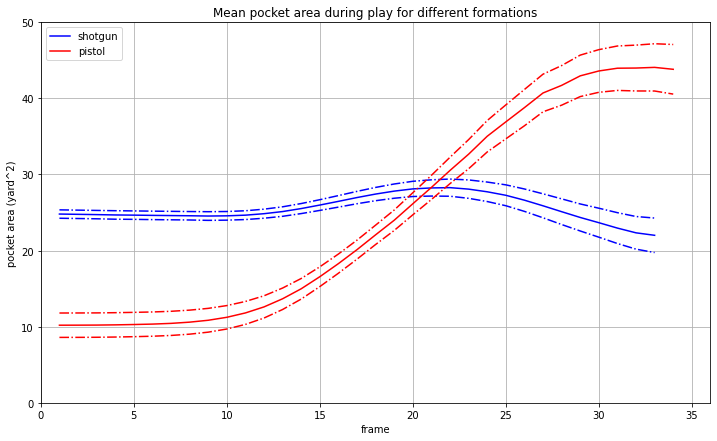

In [30]:
means_per_type = df_area_plays.groupby(['offenseFormation']).mean()

means_per_type_and_frame = df_area_plays.groupby(['offenseFormation', 'frameId']).mean()
stds_per_type_and_frame = df_area_plays.groupby(['offenseFormation', 'frameId']).std()
plt.figure(figsize = (12,7))
plt.title('Mean pocket area during play for different formations')

plt.plot(means_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])], 'b', label = 'shotgun')
plt.plot(means_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])]+stds_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])]/np.sqrt(len(stds_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])])), 'b-.')
plt.plot(means_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])]-stds_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])]/np.sqrt(len(stds_per_type_and_frame.loc['SHOTGUN','Area'].iloc[:round(means_per_type.loc['SHOTGUN','te'])])), 'b-.')

plt.plot(means_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])], 'r', label = 'pistol')
plt.plot(means_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])]+stds_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])]/np.sqrt(len(stds_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])])), 'r-.')
plt.plot(means_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])]-stds_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])]/np.sqrt(len(stds_per_type_and_frame.loc['SINGLEBACK','Area'].iloc[:round(means_per_type.loc['SINGLEBACK','te'])])), 'r-.')

plt.ylim([0,50])
plt.xlim([0,36])

plt.xlabel('frame')
plt.ylabel('pocket area (yard^2)')
plt.grid()
plt.legend()

In [31]:
print(means_per_type_and_frame)

                               Area       playId        gameId         te  \
offenseFormation frameId                                                    
EMPTY            1        24.306629  2098.163666  2.021098e+09  28.420622   
                 2        24.265666  2098.163666  2.021098e+09  28.420622   
                 3        24.206832  2098.163666  2.021098e+09  28.420622   
                 4        24.193116  2098.163666  2.021098e+09  28.420622   
                 5        24.160013  2098.163666  2.021098e+09  28.420622   
...                             ...          ...           ...        ...   
WILDCAT          14       28.794150  3621.000000  2.021102e+09  19.000000   
                 15       29.712550  3621.000000  2.021102e+09  19.000000   
                 16       31.048950  3621.000000  2.021102e+09  19.000000   
                 17       32.506000  3621.000000  2.021102e+09  19.000000   
                 18       33.817050  3621.000000  2.021102e+09  19.000000   

In [26]:
TEAMS = df_area_plays.possessionTeam.unique()
TEAMS

array(['TB', 'DAL', 'ATL', 'PHI', 'BUF', 'PIT', 'NYJ', 'CAR', 'MIN',
       'CIN', 'DET', 'SF', 'HOU', 'JAX', 'IND', 'SEA', 'ARI', 'TEN',
       'LAC', 'WAS', 'CLE', 'KC', 'NE', 'MIA', 'NO', 'GB', 'NYG', 'DEN',
       'CHI', 'LA', 'LV', 'BAL'], dtype=object)

In [32]:
means_per_team_and_frame = df_area_plays.groupby(['possessionTeam', 'frameId']).mean()
means_per_team_and_frame.index.get_level_values(0).unique()

                             Area       playId        gameId         te  \
possessionTeam frameId                                                    
ARI            1        26.133979  1962.537736  2.021098e+09  31.481132   
               2        26.127590  1962.537736  2.021098e+09  31.481132   
               3        26.116497  1962.537736  2.021098e+09  31.481132   
               4        26.107437  1962.537736  2.021098e+09  31.481132   
               5        25.995662  1962.537736  2.021098e+09  31.481132   
...                           ...          ...           ...        ...   
WAS            58       17.376841  1584.800000  2.021100e+09  60.800000   
               59       12.777701   642.333333  2.021101e+09  62.000000   
               60       11.873824   660.000000  2.021101e+09  63.000000   
               61       10.215277   660.000000  2.021101e+09  63.000000   
               62       10.214231   660.000000  2.021101e+09  63.000000   

                        

/tmp/ipykernel_6455/70497178.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



/tmp/ipykernel_6455/3644118495.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_6455/3644118495.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_6455/3644118495.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



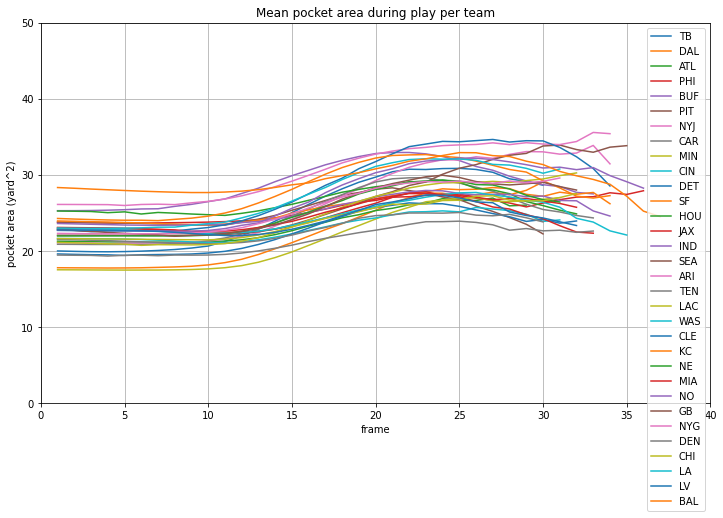

In [36]:
TEAMS = df_area_plays.possessionTeam.unique()

means_per_team = df_area_plays.groupby(['possessionTeam']).mean()

means_per_team_and_frame = df_area_plays.groupby(['possessionTeam', 'frameId']).mean()
stds_per_team_and_frame = df_area_plays.groupby(['possessionTeam', 'frameId']).std()

plt.figure(figsize = (12,7))
plt.title(f'Mean pocket area during play per team')
for team in TEAMS: 

    plt.plot(means_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])], label = team)
    #plt.plot(means_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])]+stds_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])]/np.sqrt(len(stds_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])])), '-.')
    #plt.plot(means_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])]-stds_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])]/np.sqrt(len(stds_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])])), '-.')

plt.ylim([0,50])
plt.xlim([0,40])

plt.xlabel('frame')
plt.ylabel('pocket area (yard^2)')
plt.grid()
plt.legend()
plt.show()

In [55]:
print(means_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])].mean())
def mean_area_value_by_integrate(team):
    return np.trapz(means_per_team_and_frame.loc[team,'Area'].iloc[:round(means_per_team.loc[team,'te'])], dx=1)#/means_per_team.loc[team,'te']

res = {'meanArea' : [mean_area_value_by_integrate(team) for team in TEAMS],
        'team' : TEAMS}
df_area_mean = pd.DataFrame(res)
print(df_area_mean)

29.386131999048228
       meanArea team
0    734.311999   TB
1    647.427965  DAL
2    656.632896  ATL
3    894.755542  PHI
4    927.137649  BUF
5    729.628420  PIT
6    885.439652  NYJ
7    795.108034  CAR
8    650.682047  MIN
9    692.808447  CIN
10   702.499259  DET
11   850.952579   SF
12   822.308038  HOU
13   766.473034  JAX
14   839.585739  IND
15   911.121632  SEA
16  1005.869060  ARI
17   662.770503  TEN
18   770.482700  LAC
19   831.610337  WAS
20   941.324186  CLE
21   928.363979   KC
22   756.758202   NE
23   782.612264  MIA
24   960.896045   NO
25   795.675491   GB
26   770.786299  NYG
27   685.825920  DEN
28   746.678921  CHI
29   823.066669   LA
30   747.182716   LV
31  1060.843978  BAL


In [59]:

plays_w_features = pd.merge(df_area_features,df_play,how="left",on = ["playId","gameId"])
plays_w_features_wo_PA = plays_w_features[plays_w_features.pff_playAction == 0]
means_df = plays_w_features_wo_PA.groupby("possessionTeam").mean().reset_index()
means_df['calcMeanArea'] = df_area_mean.meanArea
fig_bar_plot_team(means_df, 'calcMeanArea', 'possessionTeam', y_legend = "Mean pocket area", ascending_metric = False, imagette_size = 75)

/tmp/ipykernel_6455/1913280104.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [18]:
list_all_tracking = []
for i in range(1,8):
    list_all_tracking.append(pd.read_csv(f"data/week{i}.csv"))
df_all_tracking = pd.concat(list_all_tracking)

list_play_duration = []
for gameId in tqdm(df_play.gameId.unique()):
    playIds = df_play[df_play.gameId==gameId].playId.unique()
    playIds.sort()
    for playId in playIds:
        selected_tracking_df = df_all_tracking[(df_all_tracking.playId==playId)&(df_all_tracking.gameId==gameId)].copy()
        list_play_duration.append(np.max(selected_tracking_df.frameId))


100%|██████████| 122/122 [03:55<00:00,  1.93s/it]


8557
29


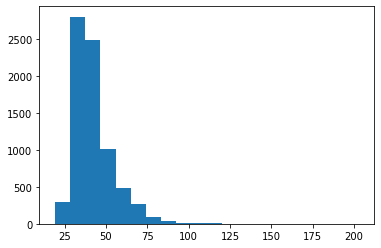

In [24]:
print(len(list_play_duration))
plt.hist(list_play_duration, bins=20)
plt.plot()
print(len(np.where(np.array(list_play_duration) > 100)[0]))